In [1]:
import pyreadr 
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_ml = pyreadr.read_r(os.path.join(os.path.expanduser('~'),'Downloads','data_ml.RData'))["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)
data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

features = list(data_ml.columns[2:95])
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index='date',columns='stock_id',values='R1M_Usd')     

Text(0.5, 0, 'Predictor')

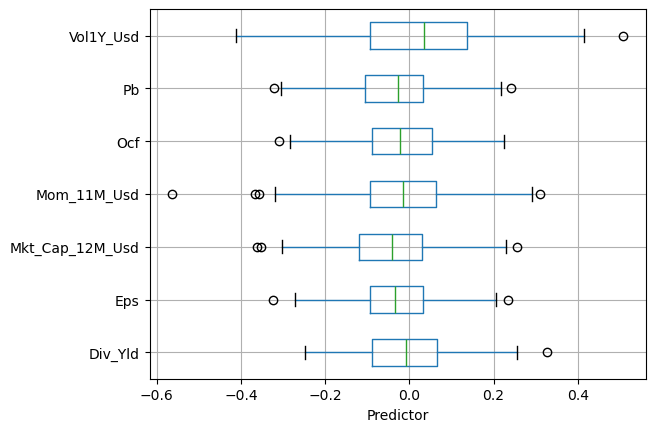

In [3]:
data_ml_corr = data_ml[features_short + ["R1M_Usd", "date"]].groupby('date').corr().R1M_Usd.reset_index(level=1)
data_ml_corr = data_ml_corr.pivot_table(index='date',columns='level_1', values='R1M_Usd')
data_ml_corr.drop(columns='R1M_Usd').boxplot(vert=False)
plt.xlabel('Predictor')

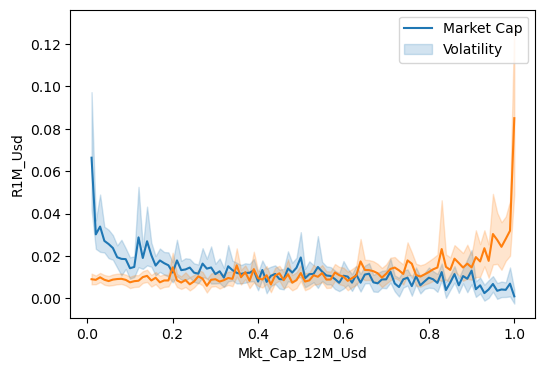

In [4]:
plt.figure(figsize=(6, 4))

sns.lineplot(x=data_ml["Mkt_Cap_12M_Usd"], y=data_ml["R1M_Usd"])
sns.lineplot(x=data_ml["Vol1Y_Usd"], y=data_ml["R1M_Usd"])
plt.legend(labels=['Market Cap', 'Volatility'])


c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

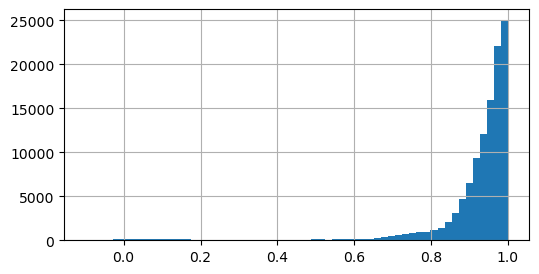

In [5]:
plt.figure(figsize=(6, 3))

data_ml_feat = data_ml[["stock_id"]+ features]                                 
data_ml_feat_melt = pd.melt(data_ml_feat, id_vars="stock_id")
autocorrs = data_ml_feat_melt.groupby(['stock_id', 'variable']).value.apply(pd.Series.autocorr, lag=1)
autocorrs = autocorrs.reset_index()
autocorrs.value.hist(bins=60, range=(-0.1,1))

<BarContainer object of 100 artists>

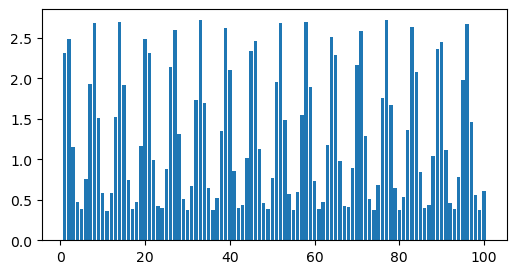

In [6]:
plt.figure(figsize=(6, 3))
length = 100
x = np.arange(1, length + 1)
data = np.exp(np.sin(x))
plt.bar(x, data)


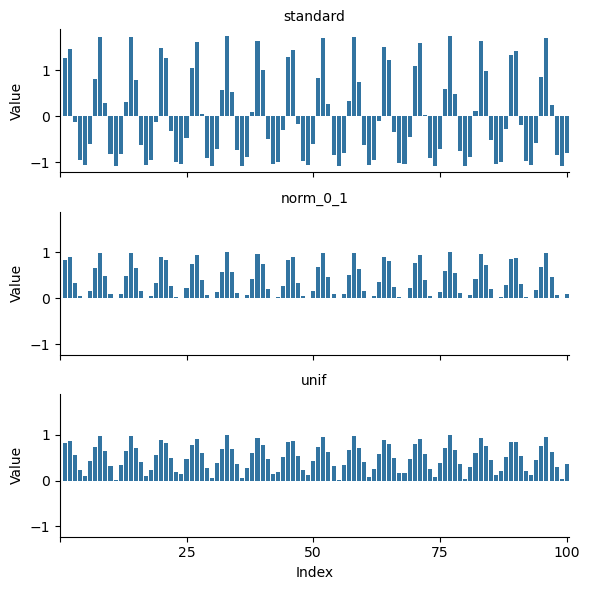

In [7]:
data_norm = pd.DataFrame()
data_norm['index'] = x
data_norm['standard'] = (data - data.mean()) / data.std(ddof=1)
data_norm['norm_0_1'] = (data - np.min(data)) / (np.max(data) - np.min(data))
data_norm['unif'] = (np.argsort(np.argsort(data)) + 1) / len(data)
data_norm_melt  = pd.melt(data_norm, id_vars = "index", var_name ="Type")

g = sns.FacetGrid(data_norm_melt, row="Type", height=2, aspect=3, sharex=True, sharey=True)
g.map_dataframe(sns.barplot, x="index", y="value", dodge=False)
g.set_titles(row_template="{row_name}")
g.set_xlabels("Index")
g.set_ylabels("Value")

for ax in g.axes.flat:
    ax.set_xticks([-1, 24, 49, 74, 99])
plt.show()

<Axes: ylabel='Frequency'>

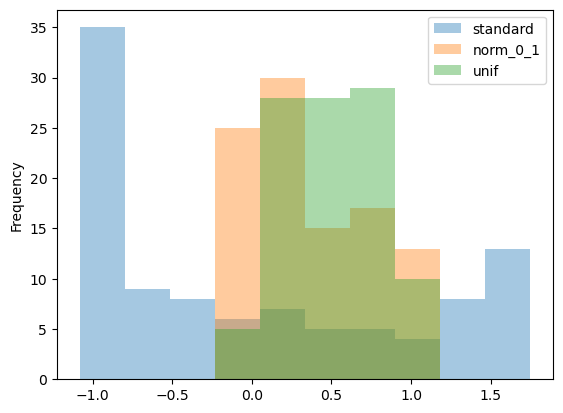

In [8]:
data_norm.set_index('index').plot.hist(alpha=0.4)

In [9]:
firm = np.repeat([1, 2, 3], 3)
date = np.tile([1, 2, 3], 3)
cap = np.array([10,50,100, 
        15,10,15,
        200,120,80])
returns = np.array([0.06,0.01,-0.06, 
        -0.03,0.00,0.02,
        -0.04,-0.02,0.00])
data_toy = pd.DataFrame({
    'firm': firm,
    'date': date,
    'cap': cap,
    'return': returns
})
data_toy['cap_0_1']= data_toy.groupby('date')['cap'].transform(lambda x:(x - np.min(x)) / (np.max(x) - np.min(x)))
data_toy['cap_u']= data_toy.groupby('date')['cap'].transform(lambda x:(np.argsort(np.argsort(x)) + 1) / len(x))
data_toy

,firm,date,cap,return,cap_0_1,cap_u
0,1,1,10,0.06,0.000000,0.333333
1,1,2,50,0.01,0.363636,0.666667
2,1,3,100,-0.06,1.000000,1.000000
3,2,1,15,-0.03,0.026316,0.666667
4,2,2,10,0.00,0.000000,0.333333
5,2,3,15,0.02,0.000000,0.333333
6,3,1,200,-0.04,1.000000,1.000000
7,3,2,120,-0.02,1.000000,1.000000
8,3,3,80,0.00,0.764706,0.666667


In [10]:
X = data_toy['cap_0_1'] 
y = data_toy['return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
regression_results = model.summary2().tables[1]
regression_results.iloc[:,:4].round(3)

c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Coef.,Std.Err.,t,P>|t|
const,0.016,0.014,1.185,0.275
cap_0_1,-0.050,0.021,-2.326,0.053


In [11]:
X = data_toy['cap_u'] 
y = data_toy['return']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
regression_results = model.summary2().tables[1]
regression_results.iloc[:,:4].round(3)

c:\Users\SE24171\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Coef.,Std.Err.,t,P>|t|
const,0.06,0.020,3.028,0.019
cap_u,-0.10,0.028,-3.634,0.008
